In [1]:
import glob, tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time

import torch
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import torch.optim as optim

#
import torch.nn.functional as F
from torch.autograd import Variable


import sys
sys.path.append("/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages")



#from mskml.dataset.MSKDataset import MSKDataset
#from mskml.utils.timeseries_utils import *
#from mskml.utils.train_utils import *

### Get Dataset

In [2]:
class TimeseriesDataset(torch.utils.data.Dataset):   
    def __init__(self, X, y, seq_len=1):
        self.X = X
        self.y = y
        self.seq_len = seq_len
        self.size = self.seq_len

    def __len__(self):
        return self.X.__len__() - (self.seq_len-1)

    def __getitem__(self, index):
        return (self.X[index:index+self.seq_len], self.y[index+self.seq_len-1])

In [3]:
df = pd.read_csv("gme_out.csv", dtype="float64")
df = df.rename(columns={'GME': 'Stock'})
df.Stock = df.Stock.mask(df.Stock.lt(0),-1)
df.Stock = df.Stock.mask(df.Stock.gt(0),1)

print(df.head(7))

X_data, y_data = df.drop(columns=['Stock']), df.Stock.values
#X_data.head(8)
#y_data[:8]

   Stock     GME_vol    GME_high     GME_low  positive  neutral  negative
0    1.0  50566100.0  413.980011  250.000000    2852.0  11119.0    1723.0
1   -1.0  37382200.0  322.000000  212.000000     473.0    411.0       0.0
2   -1.0  78183100.0  158.000000   74.220001      14.0   1488.0       0.0
3    1.0  42698500.0  113.400002   85.250000     524.0   2119.0       0.0
4   -1.0  62427300.0   91.500000   53.330002     504.0   1167.0       0.0
5    1.0  81345000.0   95.000000   51.090000     636.0    973.0     989.0
6   -1.0  25687300.0   72.660004   58.020000       0.0    287.0       0.0


In [4]:
X = np.where(np.isnan(X_data), float(0.000), X_data)
y = np.where(np.isnan(y_data), float(0.000), y_data)
#X_test = np.where(np.isnan(X_test), 0, X_test)
#y_test = np.where(np.isnan(y_test), 0, y_test)

print(X[:4])

from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X = mm.fit_transform(X)
#y = mm.fit_transform(y.reshape(-1, 1))
#y = y.ravel().tolist()


#dataset = np.hstack((X_trans,y_trans))
print(X[:8])
print(y[:8])

[[5.05661000e+07 4.13980011e+02 2.50000000e+02 2.85200000e+03
  1.11190000e+04 1.72300000e+03]
 [3.73822000e+07 3.22000000e+02 2.12000000e+02 4.73000000e+02
  4.11000000e+02 0.00000000e+00]
 [7.81831000e+07 1.58000000e+02 7.42200012e+01 1.40000000e+01
  1.48800000e+03 0.00000000e+00]
 [4.26985000e+07 1.13400002e+02 8.52500000e+01 5.24000000e+02
  2.11900000e+03 0.00000000e+00]]
[[0.33221459 1.         0.83593531 1.         1.         1.        ]
 [0.24394731 0.75146584 0.68574362 0.16584853 0.03696376 0.        ]
 [0.51711263 0.3083304  0.14118019 0.00490884 0.13382498 0.        ]
 [0.27954037 0.18781918 0.1847753  0.18373072 0.19057469 0.        ]
 [0.41162628 0.12864438 0.05861429 0.17671809 0.10495548 0.        ]
 [0.5382818  0.13810154 0.04976088 0.2230014  0.08750787 0.57399884]
 [0.16564901 0.07773786 0.0771511  0.         0.02581167 0.        ]
 [0.17338719 0.03542382 0.03169835 0.         0.01331055 0.        ]]
[ 1. -1. -1.  1. -1.  1. -1. -1.]


In [151]:
num_examples = len(X)
num_train = int(num_examples * 0.8)
print(num_train)
X_train = X[:num_train]
y_train = y[:num_train]

X_test = X[num_train:]
y_test = y[num_train:]

my_seq = 4

print(" Length of X_train {0}".format(len(X_train)))
print(" Length of X_test {0}".format(len(X_test)))



train_dataset = TimeseriesDataset(X_train, y_train, seq_len=my_seq)
test_dataset = TimeseriesDataset(X_test, y_test, seq_len=my_seq)

num_examples = len(train_dataset)
#train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 1, shuffle = False)

109
 Length of X_train 109
 Length of X_test 28


### Set DataLoader

In [143]:
BATCH_SIZE = 1

#num_examples = len(train_dataset)
#print(num_examples)
# why 98%?
#num_train = int(num_examples * 0.8)
#print(num_train)
#train_sampler = SubsetRandomSampler(torch.arange(num_train))

#### TRAIN
train_dataloader = DataLoader(train_dataset, 
                              batch_size=BATCH_SIZE,
                              num_workers=0,
                              #sampler=train_sampler,
                              pin_memory=True,
                              drop_last=False)

#### TEST 
test_dataloader = DataLoader(test_dataset, 
                              batch_size=BATCH_SIZE,
                              num_workers=0,
                              #sampler=train_sampler,
                              pin_memory=True,
                              drop_last=False)

print(len(train_dataloader)*BATCH_SIZE)

106


In [144]:
data_test, label_test = next(iter(train_dataloader))
print(y[:11])
print(label_test)
#for ii in range(0, 5):
#    x_features = data_test[ii]
#    y_label = label_test[ii]
#    y_orig = y
#    print("Day {0}: My features \n {1}, \n \t Label {2}, Orig {3} ".format(ii, x_features,y_label,y_orig))

[ 1. -1. -1.  1. -1.  1. -1. -1.  1. -1.  1.]
tensor([1.], dtype=torch.float64)


### Set Model

In [145]:
class LSTM_Model(nn.Module):
    def __init__(self, 
                 input_size, 
                 output_size,
                 hidden_size=128):
        
        super(LSTM_Model, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.lstm   = nn.LSTM(self.input_size, 
                              self.hidden_size,
                              batch_first=True, 
                              num_layers=1) # If this is >1, this changes the output shape, FYI
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, x):
        h_0 = Variable(torch.zeros(
            1, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            1, x.size(0), self.hidden_size))
        
        x, (h_n, c_n) = self.lstm(x, (h_0, c_0))
        h_out = h_n.view(-1, self.hidden_size)
        x = self.linear(h_out)
        
        #x, _ = self.lstm(x)
        #x = self.linear(x.squeeze)
        
        return x

In [76]:
def train(epochs, optimizer, criterion, device, train_dataloader, model):
    # See what the scores are before training
    # Note that element i,j of the output is the score for tag j for word i.
    # Here we don't need to train, so the code is wrapped in torch.no_grad()
    #model = model.float()
    #data_test, label_test = next(iter(train_dataloader))
    #with torch.no_grad():
    #   tag_scores = model(data_test)
    #    print(tag_scores)
    
    #model.train(True)
    for epoch in range(epochs):
        print('EPOCH {}:'.format(epoch + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        running_loss=0
        model.train(True)# (True)
        for i, data in enumerate(train_dataloader):
            # Every data instance is an input + label pair
            inputs, labels = data

            # Make predictions for this batch
            
            #print("my inputs")
            #print(inputs.dtype)
            #print(" my labels ")
            #print(labels.dtype)
            
            outputs = model(inputs.float())
            # Zero your gradients for every batch!
            optimizer.zero_grad()
            
            # Compute the loss and its gradients
            loss = criterion(outputs.squeeze(), labels.float().squeeze())
            #print(loss.dtype)
            loss.backward()

            # Adjust learning weights
            optimizer.step()
            running_loss += loss.item()
            
        if epoch % 10 == 0:
            print("output are ")
            print(outputs.squeeze())
            ##print("inputs are ")
            #print(inputs)
            print(" labels are below ")
            print(labels.shape)
        print(" Epoch {0}, train loss {1}".format(epoch, running_loss))
        running_loss=0
        

In [77]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weight_file = "LSTM_Model.pt"

num_epochs = 250
learning_rate = 0.001

input_size = 6
hidden_size = 128
output_size = 1

model = LSTM_Model(input_size = input_size,  output_size = output_size)
model.to(device)

criterion = nn.MSELoss()
#criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Train Model

In [78]:
train(
    epochs=num_epochs,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    train_dataloader=train_dataloader,
    model=model
)

EPOCH 1:
output are 
tensor(0.0035, grad_fn=<SqueezeBackward0>)
 labels are below 
torch.Size([1])
 Epoch 0, train loss 108.6127051115036
EPOCH 2:
 Epoch 1, train loss 106.9472963809967
EPOCH 3:
 Epoch 2, train loss 106.48024767637253
EPOCH 4:
 Epoch 3, train loss 106.17657762765884
EPOCH 5:
 Epoch 4, train loss 105.91642594337463
EPOCH 6:
 Epoch 5, train loss 105.63531649112701
EPOCH 7:
 Epoch 6, train loss 105.24050408601761
EPOCH 8:
 Epoch 7, train loss 104.58385181427002
EPOCH 9:
 Epoch 8, train loss 103.60955798625946
EPOCH 10:
 Epoch 9, train loss 102.21226242184639
EPOCH 11:
output are 
tensor(-0.0732, grad_fn=<SqueezeBackward0>)
 labels are below 
torch.Size([1])
 Epoch 10, train loss 100.09965258836746
EPOCH 12:
 Epoch 11, train loss 97.57512902468443
EPOCH 13:
 Epoch 12, train loss 95.00705292075872
EPOCH 14:
 Epoch 13, train loss 91.35963471107243
EPOCH 15:
 Epoch 14, train loss 88.89381995634176
EPOCH 16:
 Epoch 15, train loss 87.18910430523101
EPOCH 17:
 Epoch 16, train lo

In [146]:
my_model_results=[]
print(len(train_dataloader))
for i, data in enumerate(train_dataloader):
    # Every data instance is an input + label pair
    inputs, labels = data
    
    outputs = model(inputs.float())
    results = outputs.cpu().detach().numpy()
    #my_model_results.append(results[0][0])
    #print(results.shape)
    my_model_results.append(results)
    
my_res = [ 1 if xx[0] > 0 else -1 for xx in my_model_results]


106


In [147]:
my_test_results=[]
print(len(test_dataloader))
model.train(False)

for i, data in enumerate(test_dataloader):
    # Every data instance is an input + label pair
    inputs, labels = data
    
    outputs = model(inputs.float())
    results = outputs.cpu().detach().numpy()
    #my_model_results.append(results[0][0])
    #print(results.shape)
    my_test_results.append(results)
    
my_test_res = [ 1 if xx[0] > 0 else -1 for xx in my_test_results]

print(len(my_test_res))

25
25


In [208]:
def getAcc(l1, l2):
    matches = 0
    no_matches = 0
    print(len(l1))
    print(len(l2))
    for ii, ee in enumerate(list(zip(l1,l2))):
        l1_element = ee[0]
        l2_element = ee[1]
        if l1_element < 0 and l2_element < 0:
            matches+=1
        elif l1_element > 0 and l2_element > 0:
            matches+=1
        else:
            no_matches+=1
    acc = matches/len(l1)  
    miss = no_matches/len(l1)
    return acc, miss

25


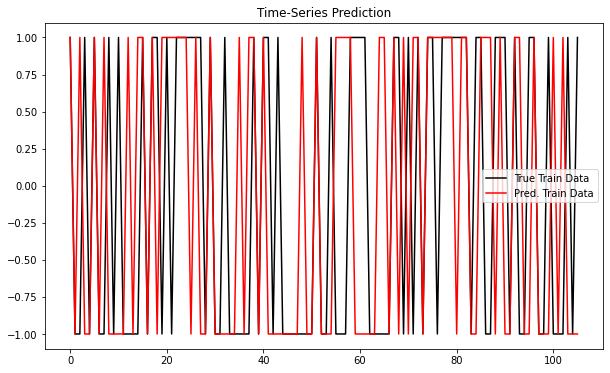

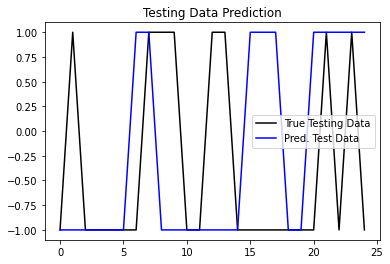

In [214]:
data_predict = np.array(my_res).reshape(-1,1) # numpy conversion
dataY_train_plot = np.array(y_train).reshape(-1,1)
dataY_test_plot = np.array(y_test).reshape(-1,1)

data_test_predict = np.array(my_test_res).reshape(-1,1) # numpy conversion
print(len(data_test_predict))


#data_predict = mm.inverse_transform(data_predict) # reverse transformation
#dataY_plot = mm.inverse_transform(dataY_plot)

true_test, true_train, preds, test = [], [], [], []

for i in range(len(dataY_train_plot)):
    true_train.append(dataY_train_plot[i][0])
    
for i in range(len(dataY_test_plot)):
    true_test.append(dataY_test_plot[i][0])
    
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
    
for i in range(len(data_test_predict)):
    test.append(data_test_predict[i][0])

plt.figure(figsize=(10,6)) #plotting


true_diff = np.diff(true_train)
true_test_diff = np.diff(true_test)
preds_diff = np.diff(preds)
test_diff = np.diff(test)

plt.plot(true_train[:-my_seq+1], label='True Train Data',c='k') # actual plot
plt.plot(preds, label='Pred. Train Data',c='r') # predicted plot

#print(preds)
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show() 


plt.title("Testing Data Prediction")
plt.plot(true_test[:-my_seq+1], label='True Testing Data',c='k') # predicted plot
plt.plot(test, label='Pred. Test Data',c='b') # predicted plot
plt.legend()
plt.savefig("test_nn.png",dpi=300)
plt.show()

In [215]:
#num_examples
print(" true lenght ",len(true_test))
print (" true train len ", len(true_train))
print (" true test len ", len(true_test))

 true lenght  28
 true train len  109
 true test len  28


In [216]:
train_acc, train_miss = getAcc(true_train[:-my_seq+1], preds)

106
106


In [217]:
print(acc, " ", train_miss)

0.5754716981132075   0.42452830188679247


In [218]:
test_acc, test_miss = getAcc(true_test[:-my_seq+1], test)

25
25


In [219]:
print(test_acc, " ", test_miss)

0.52   0.48
